# CrimeCast: Forecasting Crime Categories

## About:
This dataset offers a comprehensive snapshot of criminal activities within the city. It encompasses various aspects of each incident, including date, time, location, victim demographics, and more.
## Goal:
By leveraging machine learning techniques, participants can analyze this rich dataset to predict crime categories, enhance law enforcement strategies, and bolster public safety measures.

# 1. Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
# visualization & preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# saving
import joblib

# models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 2. Data Visualization

In [3]:
# train.csv
train_crimes = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
train_crimes.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [4]:
# test.csv
test_crimes = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
test_crimes.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


Columns information:
1. Location: Location of the incident.
2. Cross_Street: Cross street near the incident.
3. Latitude: Latitude coordinate.
4. Longitude: Longitude coordinate.
5. Date_Reported: Date when the crime was reported.
6. Date_Occurred: Date when the crime occurred.
7. Time_Occurred: Time when the crime occurred.
8. Area_ID: ID of the area where the crime occurred.
9. Area_Name: Name of the area where the crime occurred.
10. Reporting_District_no: Reporting district number.
11. Part 1-2: Part classification of the crime (1 or 2).
12. Modus_Operandi: Method of operation used in the crime.
13. Victim_Age: Age of the victim.
14. Victim_Sex: Sex of the victim.
15. Victim_Descent: Descent of the victim.
16. Premise_Code: Code representing the type of premise where the crime occurred.
17. Premise_Description: Description of the premise.
18. Weapon_Used_Code: Code of the weapon used.
19. eapon_Description: Description of the weapon used.
20. Status: Status of the investigation.
21. Status_Description: Description of the status.
22. Crime_Category: Category of the crime (target variable).

In [5]:
# check for NaN values
print(f"Count of NaN values in 'train_csv': {train_crimes.isna().sum().sum()} values")
print(f"Count of NaN values in 'test_csv': {test_crimes.isna().sum().sum()} values")

Count of NaN values in 'train_csv': 49876 values
Count of NaN values in 'test_csv': 12467 values


In [6]:
# train_csv
train_crimes.isna().sum() # Cross_Street, Modus_Operandi, Victim_Sex, Victim_Descent, Weapon_Used_Code, Premise_Description, Weapon_Description HAS Nan values

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [7]:
# test_csv
test_crimes.isna().sum() # Cross_Street, Modus_Operandi, Victim_Sex, Victim_Descent, Weapon_Used_Code, Weapon_Description, Premise_Description HAS Nan values

Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
dtype: int64

In [8]:
train_crimes['Victim_Sex'].unique()

array(['M', 'X', 'F', nan, 'H'], dtype=object)

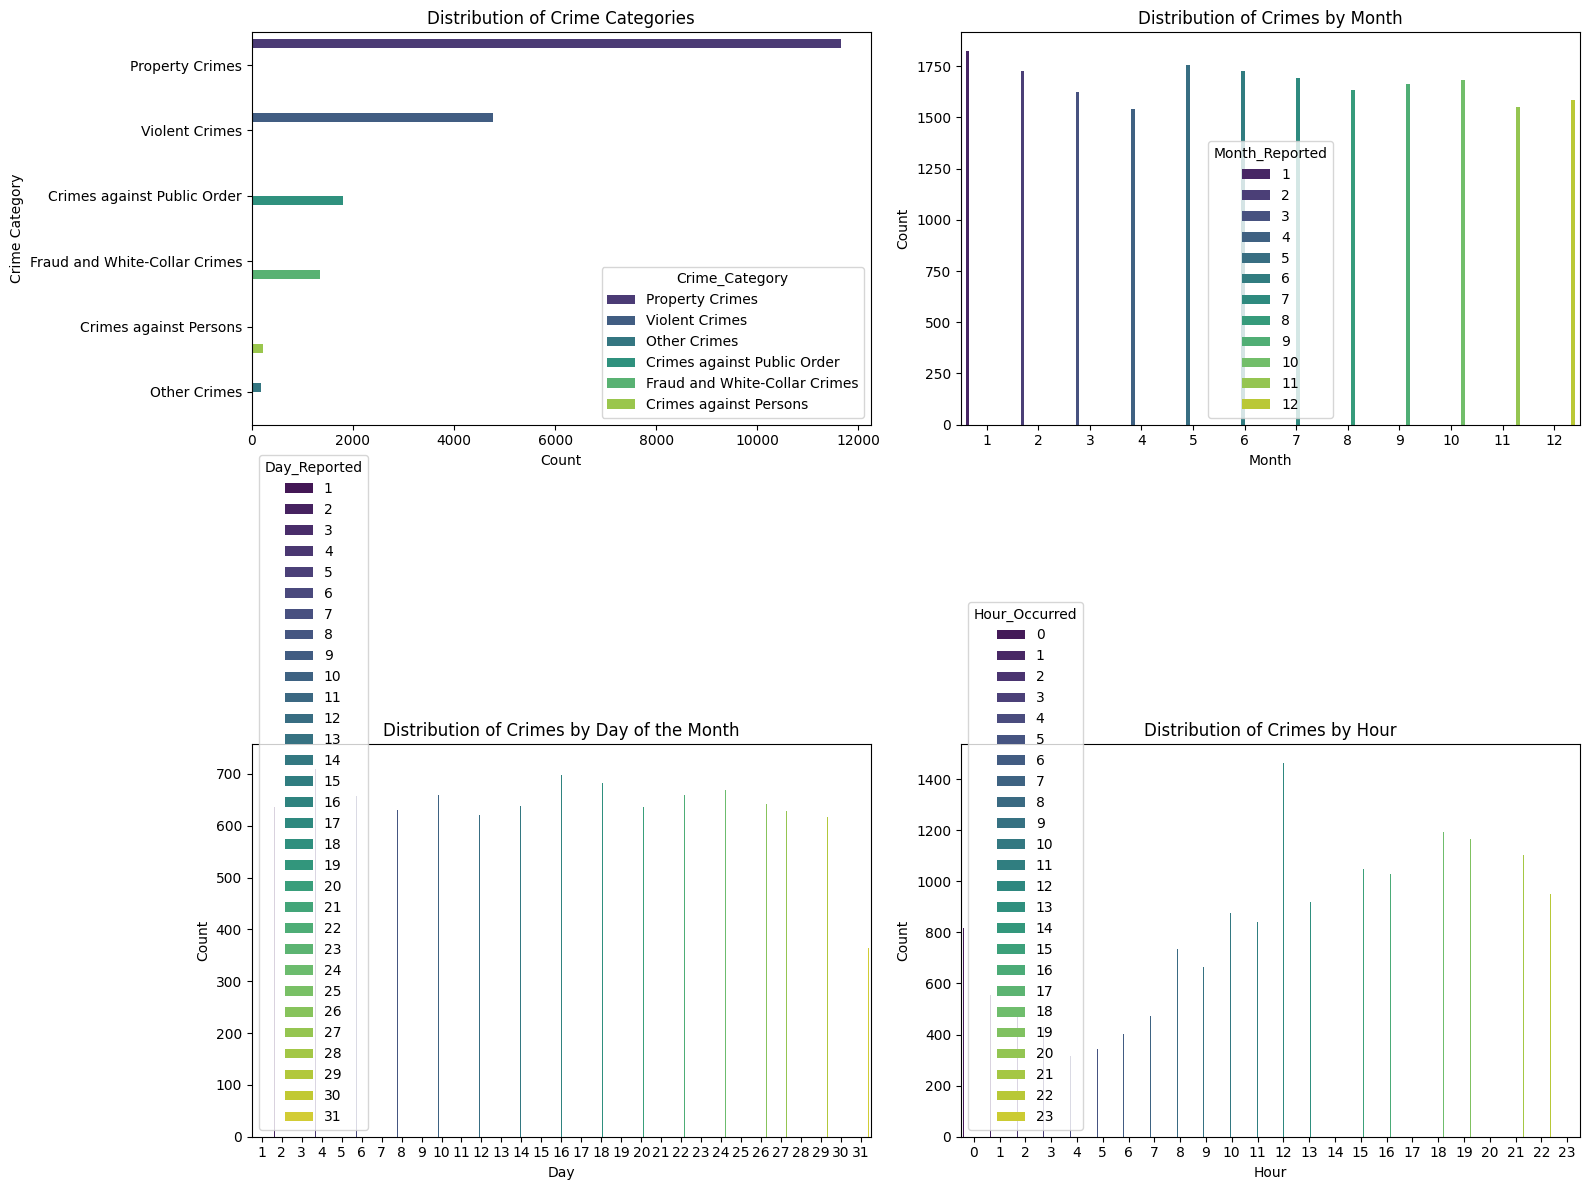

In [9]:
# Distribution of the crime categories, crimes over time

# train.csv
# Specify the date format
date_format = '%m/%d/%Y %I:%M:%S %p'  # Month/Day/Year Hour:Minute:Second AM/PM

# train.csv
# convert date columns to datetime with specified format
train_crimes['Date_Reported'] = pd.to_datetime(train_crimes['Date_Reported'], format=date_format)
train_crimes['Date_Occurred'] = pd.to_datetime(train_crimes['Date_Occurred'], format=date_format)

# extract year, month, day, and hour
train_crimes['Year_Reported'] = train_crimes['Date_Reported'].dt.year
train_crimes['Month_Reported'] = train_crimes['Date_Reported'].dt.month
train_crimes['Day_Reported'] = train_crimes['Date_Reported'].dt.day
train_crimes['Hour_Occurred'] = train_crimes['Time_Occurred'].apply(lambda x: int(x // 100))

# test.csv
# convert date columns to datetime with specified format
test_crimes['Date_Reported'] = pd.to_datetime(test_crimes['Date_Reported'], format=date_format)
test_crimes['Date_Occurred'] = pd.to_datetime(test_crimes['Date_Occurred'], format=date_format)

# extract year, month, day, and hour
test_crimes['Year_Reported'] = test_crimes['Date_Reported'].dt.year
test_crimes['Month_Reported'] = test_crimes['Date_Reported'].dt.month
test_crimes['Day_Reported'] = test_crimes['Date_Reported'].dt.day
test_crimes['Hour_Occurred'] = test_crimes['Time_Occurred'].apply(lambda x: int(x // 100))
# set up the matplotlib figure
plt.figure(figsize=(16, 12))

# distribution of crime categories
plt.subplot(2, 2, 1)
sns.countplot(y='Crime_Category', data=train_crimes, order=train_crimes['Crime_Category'].value_counts().index, palette='viridis', hue = train_crimes['Crime_Category'])
plt.title('Distribution of Crime Categories')
plt.xlabel('Count')
plt.ylabel('Crime Category')

# distribution of crimes by month
plt.subplot(2, 2, 2)
sns.countplot(x='Month_Reported', data=train_crimes, palette='viridis', hue = "Month_Reported")
plt.title('Distribution of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# distribution of crimes by day of the month
plt.subplot(2, 2, 3)
sns.countplot(x='Day_Reported', data=train_crimes, palette='viridis', hue = "Day_Reported")
plt.title('Distribution of Crimes by Day of the Month')
plt.xlabel('Day')
plt.ylabel('Count')

# distribution of crimes by hour
plt.subplot(2, 2, 4)
sns.countplot(x='Hour_Occurred', data=train_crimes, palette='viridis', hue = "Hour_Occurred")
plt.title('Distribution of Crimes by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Observations:
 - Property crimes are the most frequent, followed by violent crimes and other.
 - Crimes are fairly evenly distributed across the months, with a slight increase in some months.
 - Crimes are relatively evenly distributed across the days of the month.
 - There's a higher frequency of crimes during late afternoon to early evening (12:00 to 22:00 hours).

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


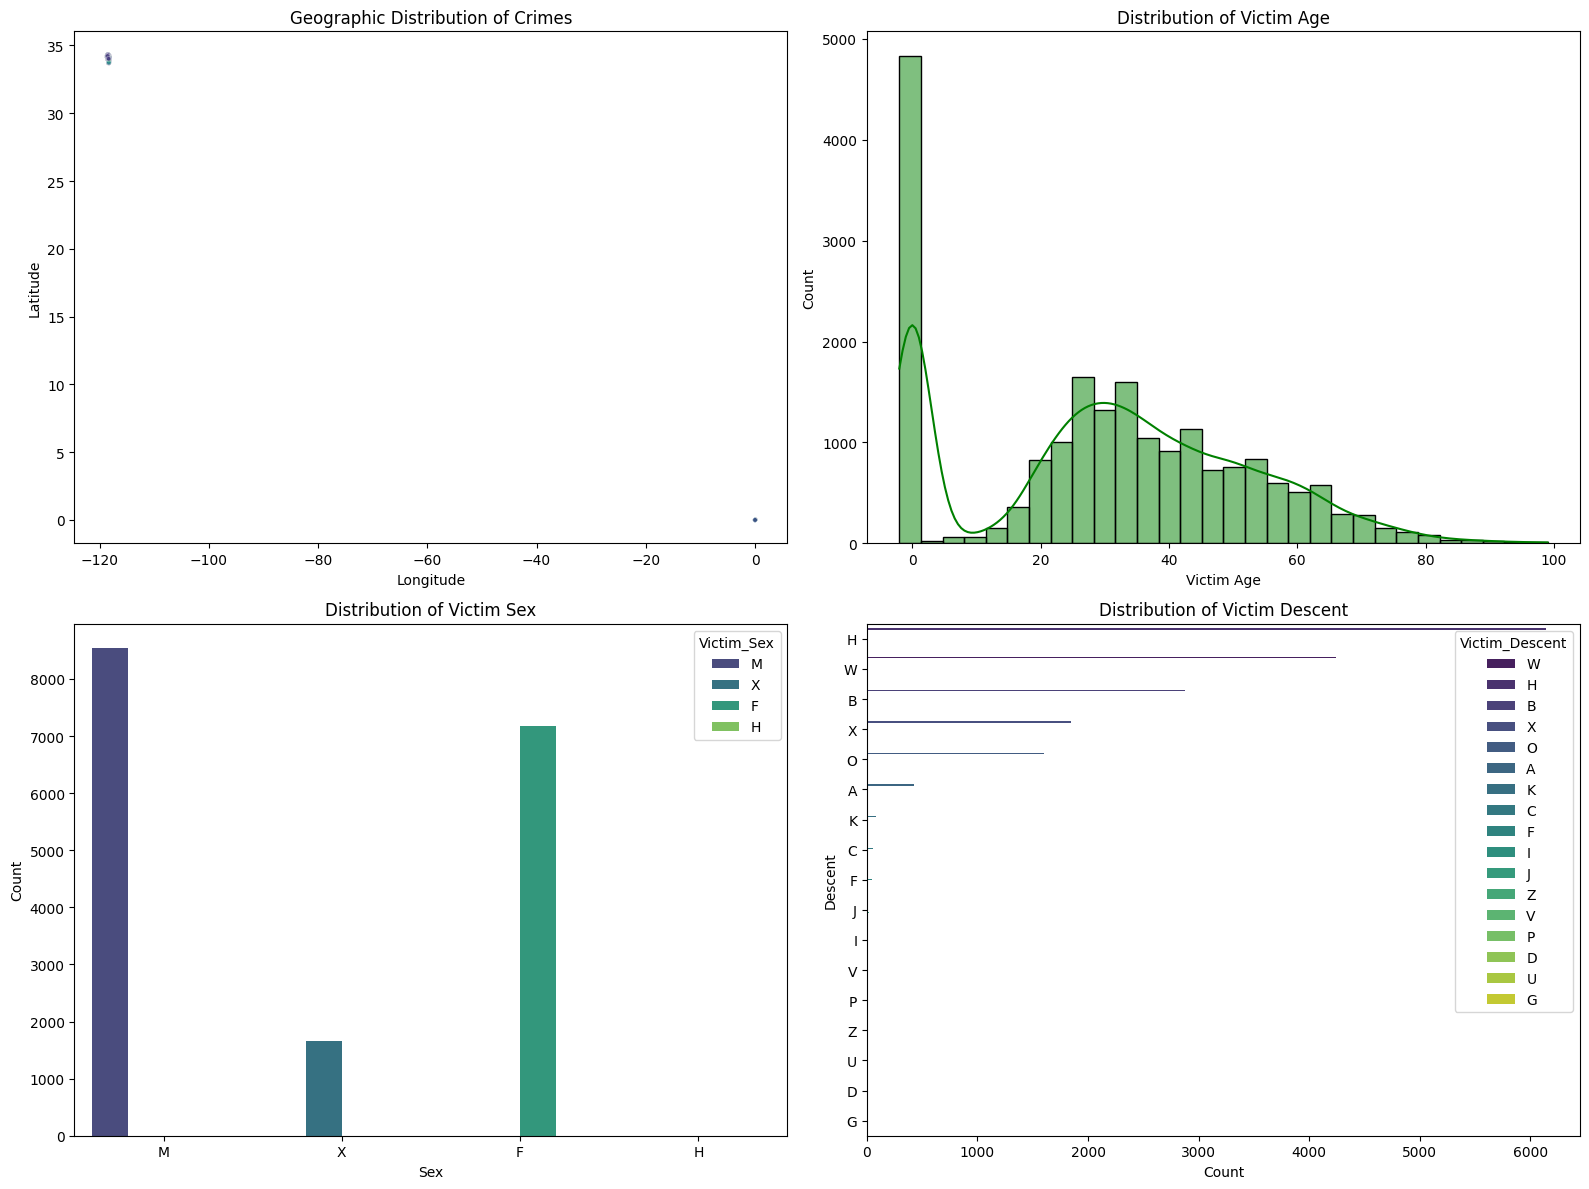

In [10]:
# Geographic distribution of crimes and analyze the demographic features of victims

# set up the matplotlib figure
plt.figure(figsize=(16, 12))

# geographic distribution of crimes
plt.subplot(2, 2, 1)
sns.scatterplot(x='Longitude', y='Latitude', hue='Crime_Category', data=train_crimes, palette='viridis', legend=None, s=10, alpha=0.5)
plt.title('Geographic Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# distribution of victim age
plt.subplot(2, 2, 2)
sns.histplot(train_crimes['Victim_Age'], bins=30, kde=True, color='green')
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Count')

# distribution of victim sex
plt.subplot(2, 2, 3)
sns.countplot(x='Victim_Sex', data=train_crimes, palette='viridis', hue = "Victim_Sex")
plt.title('Distribution of Victim Sex')
plt.xlabel('Sex')
plt.ylabel('Count')

# distribution of victim descent
plt.subplot(2, 2, 4)
sns.countplot(y='Victim_Descent', data=train_crimes, order=train_crimes['Victim_Descent'].value_counts().index, palette='viridis', hue = "Victim_Descent")
plt.title('Distribution of Victim Descent')
plt.xlabel('Count')
plt.ylabel('Descent')

plt.tight_layout()
plt.show()

Observations:
 - Crimes are spread across various locations, with certain clusters indicating high crime areas.
 - Victim age shows a right-skewed distribution, with most victims in their 20s to 40s.
 - More male victims are reported compared to female victims.
 - The descent categories have varied distributions, with some categories being more frequent.

# Conclusion of Data Visualization:
The most important features are:
 - Latitude, Longitude
 - Hour, Day, Month, Year reports
 - Area ID, name, reporting_district_no
 - Victim age, sex, descent
 - Premise code, description
 - Weapon used code, description
 - Status, description

# 3. Data Preprocessing & Cleaning

In [11]:
# Fill NaN values

# fill categorical columns with placeholders

# train.csv
train_crimes['Cross_Street'] = train_crimes['Cross_Street'].fillna('Unknown')
train_crimes['Modus_Operandi'] = train_crimes['Modus_Operandi'].fillna('Unknown')
train_crimes['Victim_Sex'] = train_crimes['Victim_Sex'].fillna('Unknown')
train_crimes['Victim_Descent'] = train_crimes['Victim_Descent'].fillna('Unknown')
train_crimes['Premise_Description'] = train_crimes['Premise_Description'].fillna('Unknown')
train_crimes['Weapon_Description'] = train_crimes['Weapon_Description'].fillna('Unknown')

# test.csv
test_crimes['Cross_Street'] = test_crimes['Cross_Street'].fillna('Unknown')
test_crimes['Modus_Operandi'] = test_crimes['Modus_Operandi'].fillna('Unknown')
test_crimes['Victim_Sex'] = test_crimes['Victim_Sex'].fillna('Unknown')
test_crimes['Victim_Descent'] = test_crimes['Victim_Descent'].fillna('Unknown')
test_crimes['Premise_Description'] = test_crimes['Premise_Description'].fillna('Unknown')
test_crimes['Weapon_Description'] = test_crimes['Weapon_Description'].fillna('Unknown')

# fill missing numerical values with the median values
train_crimes['Weapon_Used_Code'] = train_crimes['Weapon_Used_Code'].fillna(train_crimes['Weapon_Used_Code'].median())
test_crimes['Weapon_Used_Code'] = test_crimes['Weapon_Used_Code'].fillna(train_crimes['Weapon_Used_Code'].median())

In [12]:
# verify for NaN values
print(f"Count of NaN values in 'train_csv': {train_crimes.isna().sum().sum()} values")
print(f"Count of NaN values in 'test_csv': {test_crimes.isna().sum().sum()} values")

Count of NaN values in 'train_csv': 0 values
Count of NaN values in 'test_csv': 0 values


In [13]:
# Encode categorical features

label_encoders = {}
categorical_columns = ['Location', 'Cross_Street', 'Area_Name', 'Modus_Operandi',
                           'Victim_Sex', 'Victim_Descent', 'Premise_Description',
                           'Weapon_Description', 'Status', 'Status_Description']


for col in categorical_columns:
    labelE = LabelEncoder()
    train_crimes[col] = labelE.fit_transform(train_crimes[col])

    # handle unseen labels in test data
    test_crimes[col] = test_crimes[col].map(lambda s: '<unknown>' if s not in labelE.classes_ else s)
    labelE.classes_ = np.append(labelE.classes_, '<unknown>')
    test_crimes[col] = labelE.transform(test_crimes[col])

    # store the label encoder
    label_encoders[col] = labelE

In [14]:
# encode the target variable 'Crime_Category'
labelE_crime_category = LabelEncoder()
train_crimes['Crime_Category'] = labelE_crime_category.fit_transform(train_crimes['Crime_Category'])

In [15]:
# save the label encoder for later decoding
joblib.dump(labelE_crime_category, 'labelE_crime_category.pkl')

['labelE_crime_category.pkl']

In [16]:
# Scale numerical features

scaler = StandardScaler()
numerical_columns = ['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID',
                     'Reporting_District_no', 'Part 1-2', 'Victim_Age',
                     'Premise_Code', 'Weapon_Used_Code']

train_crimes[numerical_columns] = scaler.fit_transform(train_crimes[numerical_columns])
test_crimes[numerical_columns] = scaler.transform(test_crimes[numerical_columns])

In [17]:
train_crimes['Crime_Category'].unique() # labels

array([4, 5, 3, 1, 2, 0])

# 4. Model training

In [18]:
# define features and target variable for training data
X_train = train_crimes.drop(columns=['Crime_Category', 'Date_Reported', 'Date_Occurred'])
y_train = train_crimes['Crime_Category']

# prepare test data (assuming
X_test = test_crimes.drop(columns=['Date_Reported', 'Date_Occurred'])

# split the training data further into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train_split.shape, X_val_split.shape, y_train_split.shape, y_val_split.shape)

(16000, 23) (4000, 23) (16000,) (4000,)


In [19]:
# Function to evaluate models

def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred)
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    return accuracy, report, conf_matrix

In [20]:
# # GradientBoosting
# gb_model = GradientBoostingClassifier(random_state=42)
# gb_params = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=gb_params, cv=3, n_jobs=-1, verbose=1)
# grid_search_gb.fit(X_train_split, y_train_split)
# best_gb_model = grid_search_gb.best_estimator_

In [21]:
# XGBoost
xgb_refined_params = {
    'n_estimators': [90, 100, 110],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [6, 7, 8],
    'min_child_weight': [4, 5, 6],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7]
}

grid_search_xgb_refined = RandomizedSearchCV(estimator=XGBClassifier(random_state=42), param_distributions=xgb_refined_params, cv=3, n_jobs=-1, verbose=3, random_state=42, n_iter=100)
grid_search_xgb_refined.fit(X_train_split, y_train_split)
best_xgb_refined_model = grid_search_xgb_refined.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=90, subsample=0.9;, score=0.916 total time=   4.1s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=8, min_child_weight=6, n_estimators=110, subsample=1.0;, score=0.912 total time=   4.7s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.15, max_depth=6, min_child_weight=6, n_estimators=110, subsample=0.9;, score=0.912 total time=   3.7s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=110, subsample=0.9;, score=0.923 total time=   5.5s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.15, max_depth=7, min_child_weight=6, n_estimators=100, subsample=1.0;, score=0.917 total time=   3.7s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=100, subsample=1.0;, score=0.915 total time=   3.4s
[CV 2/3] END colsample_

In [22]:
# # LightGBM
# lgb_params = {
#     'num_leaves': [31, 40, 50],
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# grid_search_lgb = RandomizedSearchCV(estimator=LGBMClassifier(random_state=42), param_distributions=lgb_params, cv=3, n_jobs=-1, verbose=2, random_state=42, n_iter=100)
# grid_search_lgb.fit(X_train_split, y_train_split)
# best_lgb_model = grid_search_lgb.best_estimator_

In [23]:
# evaluate all models
models = {
    'XGBoost Refined': best_xgb_refined_model,
#     'LightGBM': best_lgb_model,
}

In [24]:
# Evaluate all models
for name, model in models.items():
    accuracy, report, conf_matrix = evaluate_model(model, X_train_split, y_train_split, X_val_split, y_val_split)

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:\n{report}")
    print(f"{name} Confusion Matrix:\n{conf_matrix}\n")

XGBoost Refined Accuracy: 0.9200
XGBoost Refined Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.53      0.58        32
           1       0.79      0.76      0.78       374
           2       0.93      0.86      0.89       267
           3       0.50      0.09      0.15        35
           4       0.97      0.96      0.96      2303
           5       0.87      0.94      0.91       989

    accuracy                           0.92      4000
   macro avg       0.78      0.69      0.71      4000
weighted avg       0.92      0.92      0.92      4000

XGBoost Refined Confusion Matrix:
[[  17    3    0    0    0   12]
 [   3  286   12    0   19   54]
 [   0   22  230    0   15    0]
 [   0   19    4    3    9    0]
 [   0   15    1    3 2213   71]
 [   7   16    0    0   35  931]]



In [25]:
# choose the best model and retrain on full training data
best_model = best_xgb_refined_model
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}")

Training Accuracy: 0.9766


In [26]:
# predict on test data
y_test_pred = best_model.predict(X_test)

In [27]:
# decode the predictions for submission
labelE_crime_category = joblib.load('labelE_crime_category.pkl')
y_test_pred_decoded = labelE_crime_category.inverse_transform(y_test_pred)
y_test_pred_decoded

array(['Violent Crimes', 'Property Crimes', 'Crimes against Public Order',
       ..., 'Violent Crimes', 'Violent Crimes', 'Property Crimes'],
      dtype=object)

In [28]:
test_crimes.reset_index(drop=True, inplace=True)
submission = pd.DataFrame({'ID':test_crimes.index + 1, 'Crime_Category': y_test_pred_decoded})
submission.to_csv('submission.csv', index = False)
submission.head()

,ID,Crime_Category
0,1,Violent Crimes
1,2,Property Crimes
2,3,Crimes against Public Order
3,4,Property Crimes
4,5,Crimes against Public Order
